In [12]:
import numpy as np # Standard python maths library

import matplotlib.pyplot as plt # Graph plotting tools
plt.rcParams['figure.figsize'] = [30, 5] # matplotlib settings, define size of graph. Edit if the graphs do not fit on your screen

import torch # Machine learning libary being used for LSTM
from torch import nn # Commonly used module of torch library

import statsmodels.api as sm

import pandas as pd
import datetime as dt

In [2]:
ricePath = r"C:\Users\ray\Documents\Summer Project\Data\Futures\Rough Rice Futures Historical Data.csv"

In [3]:
riceData = pd.read_csv(ricePath, header=[0,1])
riceData.columns = [x[0] for x in riceData.columns]

riceData.Date = pd.to_datetime(riceData.Date)

riceData = riceData.sort_values("Date")

In [4]:
class LSTM_multifeature(nn.Module):
    def __init__(self, input_features, hidden_layers_1=32, hidden_layers_2=32, hidden_layers_3=32, outputLayer=1):
        """ Instantiate the LSTM with multiple hidden layers
            In this case, I'm using two hidden layers, and a linear layer to convert the output to a single number """
        super(LSTM_multifeature, self).__init__()
        self.input_features = input_features
        self.hidden_layers_1 = hidden_layers_1
        self.hidden_layers_2 = hidden_layers_2
        self.hidden_layers_3 = hidden_layers_3
        self.lstm1 = nn.LSTMCell(self.input_features, self.hidden_layers_1)
        self.lstm2 = nn.LSTMCell(self.hidden_layers_1, self.hidden_layers_2)
        self.lstm3 = nn.LSTMCell(self.hidden_layers_2, self.hidden_layers_3)
        self.linear = nn.Linear(self.hidden_layers_3, 1)
        
        self.last_loss = 0  # For printing purposes during training
        
    def forward(self, y, future_preds=0, future_oil=None):
        """ Call the model to make predictions
            h_t and c_t are the hidden and cell states of the lstm layers
            
            This forward function runs through the data one point at a time, and stores the models output for each point
            If future_preds > 0 is passed in, the model with make predictions based on its own output. It is currently very bad at this.
        """
        outputs, num_samples = [], y.shape[0]
        h_t = torch.zeros(1, self.hidden_layers_1, dtype=torch.float32)
        c_t = torch.zeros(1, self.hidden_layers_1, dtype=torch.float32)
        h_t2 = torch.zeros(1, self.hidden_layers_2, dtype=torch.float32)
        c_t2 = torch.zeros(1, self.hidden_layers_2, dtype=torch.float32)
        h_t3 = torch.zeros(1, self.hidden_layers_2, dtype=torch.float32)
        c_t3 = torch.zeros(1, self.hidden_layers_2, dtype=torch.float32)
        
        for time_step in y.split(1, dim=0):
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            h_t3, c_t3 = self.lstm3(h_t2, (h_t3, c_t3)) # new hidden and cell states
            output = self.linear(h_t3).reshape(1) # output from the last FC layer
            outputs.append(output)
        
        if not future_oil:
            new_input = torch.cat([time_step[0], output], dim=0)[1:].reshape(1, self.input_features)
            for i in range(future_preds):
                # Mirrors the code above, using last output/prediction as input
                h_t, c_t = self.lstm1(new_input, (h_t, c_t))
                h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
                h_t3, c_t3 = self.lstm3(h_t2, (h_t3, c_t3))
                output = self.linear(h_t3).reshape(1)

                new_input = torch.cat([new_input[0], output], dim=0)[1:].reshape(1, self.input_features)
                outputs.append(output)
        
        else:
            new_input = torch.cat([time_step[0], output], dim=0)[1:].reshape(1, self.input_features)
            for i in range(future_preds):
                # Mirrors the code above, using last output/prediction as input
                h_t, c_t = self.lstm1(new_input, (h_t, c_t))
                h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
                h_t3, c_t3 = self.lstm3(h_t2, (h_t3, c_t3))
                output = self.linear(h_t3).reshape(1)

                new_input = torch.cat([new_input[0], output], dim=0)[1:].reshape(1, self.input_features)
                outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=0)
        return outputs

    
def training_loop_multifeature(n_epochs, model, optimiser, loss_fn, 
                  train_input, train_target, test_input, test_target, test=True):
    """ Train a model with provided data
        Ignorning the auto plotting part for now """
    for i in range(n_epochs):
        print("Epoch: ", i)
        def closure():
            optimiser.zero_grad()
            out = model(train_input)
            # print(list(zip(out, train_target)))
            loss = loss_fn(out, train_target)
            # print("!")
            # print(out[:10])
            # print("-")
            # print(train_target[:10])
            # print(loss)
            loss.backward()
            model.last_loss = loss
            return loss
        
        optimiser.step(closure)
        print("Loss: ", model.last_loss)
        
        # Make future predictions
    if test:
        with torch.no_grad():
            future = len(test_target)
            pred = model(torch.cat([train_input, test_input], dim=0), future_preds=future)
            print(pred.shape)
            # print(pred)
            loss = loss_fn(pred.reshape(pred.shape[1])[-future:], test_target)
            y = pred.detach().numpy()

        return (loss, y)
    
    return None

In [5]:
oilPath=r"C:\Users\ray\Documents\Summer Project\Data\Oil Prices\Europe_Brent_Spot_Price_FOB_Daily.csv"

In [6]:
oilData = pd.read_csv(oilPath, skiprows=[0,1,2,3])
oilData.columns = [x[0] for x in oilData.columns]

oilData["Date"] = pd.to_datetime(oilData.D)
oilData["Oil_Price"] = oilData.S


oilData = oilData.drop(["D", "S"], axis=1) \
                 .sort_values("Date")

# oilData = oilData.sort_values("Date")

In [7]:
joinData = riceData[["Date", "Price"]].set_index("Date").join(oilData.set_index("Date"), how="inner")

In [11]:
joinData

,Price,Oil_Price
Date,,
2007-01-19,10.360,52.29
2007-01-22,10.105,54.34
2007-01-23,10.270,53.93
2007-01-24,10.175,55.11
2007-01-25,10.190,55.67
...,...,...
2022-08-16,16.900,95.36
2022-08-17,16.665,97.22
2022-08-18,16.555,96.35


In [8]:
x = np.array(joinData)

num_features = 2
num_samples = len(x) - 1

y = torch.tensor(x[1:,0], dtype=torch.float32)
x = torch.tensor(x[:-1], dtype=torch.float32)

testLength = 500

trainX = x[:-testLength]
testX = x[-testLength:]

trainy = y[:-testLength]
testy = y[-testLength:]

lstmModel_oil = LSTM_multifeature(input_features=num_features, hidden_layers_1=32, hidden_layers_2=32, hidden_layers_3=32, outputLayer=1)
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(lstmModel_oil.parameters(), lr=0.08)

r = training_loop_multifeature(5, lstmModel_oil, optimiser, criterion, trainX, trainy, testX, testy, test=False)


Epoch:  0
Loss:  tensor(6.8942, grad_fn=<MseLossBackward0>)
Epoch:  1
Loss:  tensor(6.1081, grad_fn=<MseLossBackward0>)
Epoch:  2
Loss:  tensor(6.0408, grad_fn=<MseLossBackward0>)
Epoch:  3
Loss:  tensor(5.7814, grad_fn=<MseLossBackward0>)
Epoch:  4
Loss:  tensor(4.2160, grad_fn=<MseLossBackward0>)


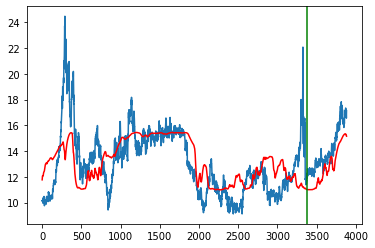

In [9]:
with torch.no_grad():
    future = 0
    pred = lstmModel_oil(x, future_preds=future)
    # print(pred[0])
    bigPred = pred.detach().numpy()

a = np.mean(bigPred)
b = bigPred+(bigPred-a)

plt.plot(y[10:])
plt.plot(bigPred[10:], color="r")
plt.axvline(x=len(b[10:])-testLength, color="g")
plt.show()

In [10]:
rainfallPath = r"C:\Users\ray\Documents\Summer Project\Data\China Precipitation\pr_timeseries_monthly_cru_1901-2021_CHN.csv"

In [11]:
rainfallData = pd.read_csv(rainfallPath, header=[2,2])
rainfallData.columns = [x[0] for x in rainfallData.columns]
rainfallData = rainfallData.rename({rainfallData.columns[0] : "Year"}, axis=1)
# rainfallData.Date = pd.to_datetime(rainfallData.Date)
# a
# riceData = riceData.sort_values("Date")

In [54]:
# rainfallData
riceData.Date[0].strftime("%B")[:3]

'Aug'

In [13]:
def fetch_precip_data(row):
    year = row.name.year
    month = row.name.strftime("%B")[:3]
    try:
        return rainfallData[rainfallData["Year"] == year][month].to_list()[0]
    except:
        return "Data not Available"

def fetch_precip_data_4monthlag(row):
    newDate = row.name - dt.timedelta(days=120)
    year = row.name.year
    month = row.name.strftime("%B")[:3]
    try:
        return rainfallData[rainfallData["Year"] == year][month].to_list()[0]
    except:
        return "Data not Available"
        

In [14]:
joinData["rainfall"] = joinData.apply(fetch_precip_data, axis=1)
joinData["rainfall4MonthLag"] = joinData.apply(fetch_precip_data_4monthlag, axis=1)

In [15]:
joinData2 = joinData[:-160]

In [36]:
x = np.array(joinData2, dtype=float)

num_features = 4
num_samples = len(x) - 1

y = torch.tensor(x[1:,0], dtype=torch.float32)
x = torch.tensor(x[:-1], dtype=torch.float32)

testLength = 500

trainX = x[:-testLength]
testX = x[-testLength:]

trainy = y[:-testLength]
testy = y[-testLength:]

lstmModel_oil = LSTM_multifeature(input_features=num_features, hidden_layers_1=32, hidden_layers_2=32, hidden_layers_3=32, outputLayer=1)
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(lstmModel_oil.parameters(), lr=0.08)

r = training_loop_multifeature(10, lstmModel_oil, optimiser, criterion, trainX, trainy, testX, testy, test=False)


Epoch:  0
Loss:  tensor(6.3219, grad_fn=<MseLossBackward0>)
Epoch:  1
Loss:  tensor(5.9279, grad_fn=<MseLossBackward0>)
Epoch:  2
Loss:  tensor(5.1877, grad_fn=<MseLossBackward0>)
Epoch:  3
Loss:  tensor(4.5920, grad_fn=<MseLossBackward0>)
Epoch:  4
Loss:  tensor(4.1130, grad_fn=<MseLossBackward0>)
Epoch:  5
Loss:  tensor(3.8586, grad_fn=<MseLossBackward0>)
Epoch:  6
Loss:  tensor(3.4504, grad_fn=<MseLossBackward0>)
Epoch:  7
Loss:  tensor(2.3350, grad_fn=<MseLossBackward0>)
Epoch:  8
Loss:  tensor(2.2680, grad_fn=<MseLossBackward0>)
Epoch:  9
Loss:  tensor(2.1811, grad_fn=<MseLossBackward0>)


tensor(10152.9082)


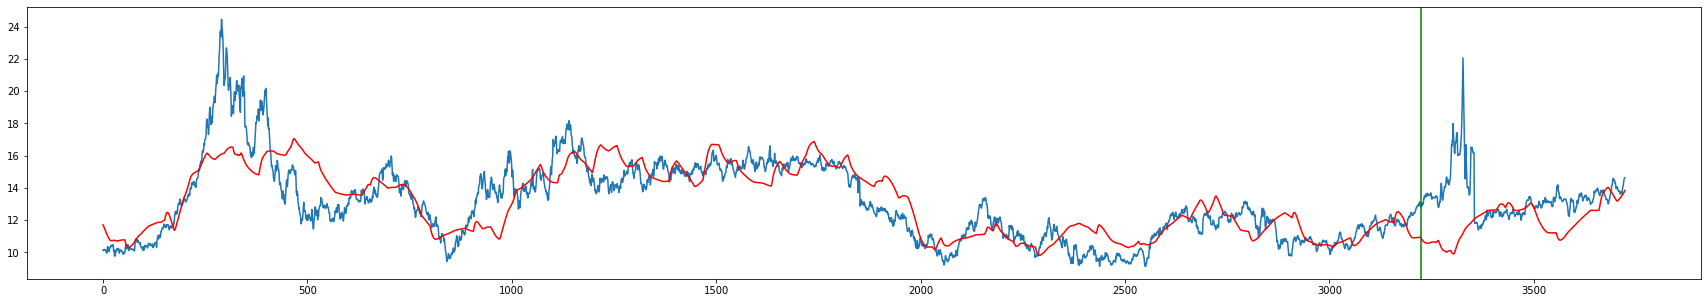

In [38]:
with torch.no_grad():
    future = 0
    pred = lstmModel_oil(x, future_preds=future)
    # print(pred[0])
    bigPred = pred.detach().numpy()

a = np.mean(bigPred)
b = bigPred+(bigPred-a)

print(sum((y - bigPred)**2))

plt.plot(y[10:])
plt.plot(bigPred[10:], color="r")
plt.axvline(x=len(b[10:])-testLength, color="g")
plt.show()

In [165]:
y

tensor([10.1050, 10.2700, 10.1750,  ..., 14.5500, 14.5750, 14.6300])

In [34]:
joinData[:-200]

,Price,Oil_Price,rainfall,rainfall4MonthLag
Date,,,,
2007-01-19,10.360,52.29,10.78,10.78
2007-01-22,10.105,54.34,10.78,10.78
2007-01-23,10.270,53.93,10.78,10.78
2007-01-24,10.175,55.11,10.78,10.78
2007-01-25,10.190,55.67,10.78,10.78
...,...,...,...,...
2021-10-28,13.280,83.40,45.77,45.77
2021-10-29,13.280,83.10,45.77,45.77
2021-11-01,13.205,84.51,19.91,19.91


In [33]:
x = np.array(joinData2[["Price", "rainfall", "rainfall4MonthLag"]], dtype=float)

num_features = 3
num_samples = len(x) - 1

y = torch.tensor(x[1:,0], dtype=torch.float32)
x = torch.tensor(x[:-1], dtype=torch.float32)

testLength = 500

trainX = x[:-testLength]
testX = x[-testLength:]

trainy = y[:-testLength]
testy = y[-testLength:]

lstmModel_oil = LSTM_multifeature(input_features=num_features, hidden_layers_1=32, hidden_layers_2=32, hidden_layers_3=32, outputLayer=1)
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(lstmModel_oil.parameters(), lr=0.08)

r = training_loop_multifeature(10, lstmModel_oil, optimiser, criterion, trainX, trainy, testX, testy, test=False)


Epoch:  0


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    future = 0
    pred = lstmModel_oil(x, future_preds=future)
    # print(pred[0])
    bigPred = pred.detach().numpy()

a = np.mean(bigPred)
b = bigPred+(bigPred-a)

plt.plot(y[10:])
plt.plot(bigPred[10:], color="r")
plt.axvline(x=len(b[10:])-testLength, color="g")
plt.show()

In [16]:
x = np.array(joinData2[["Price"]], dtype=float)

num_features = 1
num_samples = len(x) - 1

y = torch.tensor(x[1:,0], dtype=torch.float32)
x = torch.tensor(x[:-1], dtype=torch.float32)

testLength = 500

trainX = x[:-testLength]
testX = x[-testLength:]

trainy = y[:-testLength]
testy = y[-testLength:]

lstmModel_oil = LSTM_multifeature(input_features=num_features, hidden_layers_1=32, hidden_layers_2=32, hidden_layers_3=32, outputLayer=1)
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(lstmModel_oil.parameters(), lr=0.08)

r = training_loop_multifeature(10, lstmModel_oil, optimiser, criterion, trainX, trainy, testX, testy, test=False)

Epoch:  0
Loss:  tensor(6.2923, grad_fn=<MseLossBackward0>)
Epoch:  1
Loss:  tensor(4.9916, grad_fn=<MseLossBackward0>)
Epoch:  2
Loss:  tensor(704.5214, grad_fn=<MseLossBackward0>)
Epoch:  3
Loss:  tensor(35.5409, grad_fn=<MseLossBackward0>)
Epoch:  4
Loss:  tensor(8.4490, grad_fn=<MseLossBackward0>)
Epoch:  5
Loss:  tensor(7.3807, grad_fn=<MseLossBackward0>)
Epoch:  6
Loss:  tensor(6.9579, grad_fn=<MseLossBackward0>)
Epoch:  7
Loss:  tensor(14.7928, grad_fn=<MseLossBackward0>)
Epoch:  8
Loss:  tensor(6.0739, grad_fn=<MseLossBackward0>)
Epoch:  9
Loss:  tensor(5.7575, grad_fn=<MseLossBackward0>)


tensor(19634.7246)


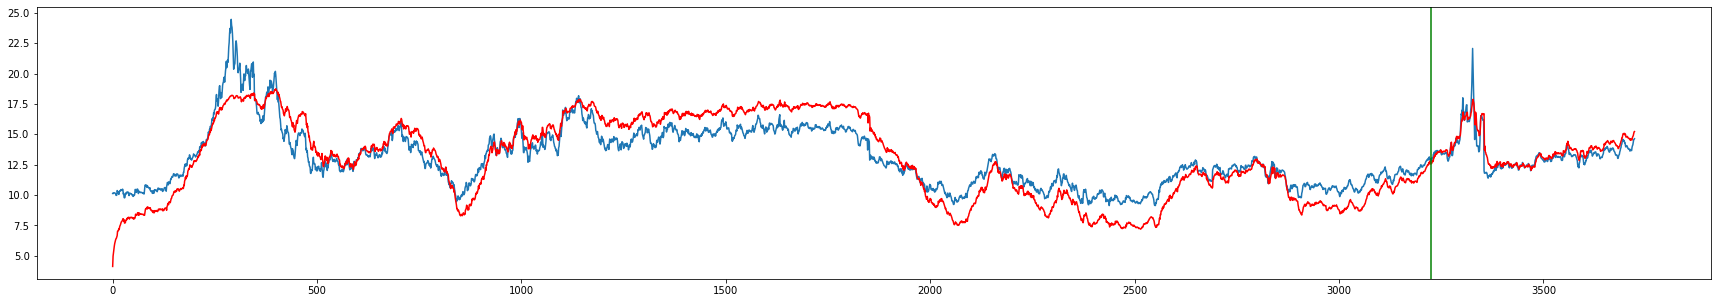

In [35]:
with torch.no_grad():
    future = 0
    pred = lstmModel_oil(x, future_preds=future)
    # print(pred[0])
    bigPred = pred.detach().numpy()

a = np.mean(bigPred)
b = bigPred+(bigPred-a)*30

print(sum((y - bigPred)**2))

plt.plot(y[10:])
plt.plot(b[10:], color="r")
plt.axvline(x=len(b[10:])-testLength, color="g")
plt.show()

tensor(19699.2598)


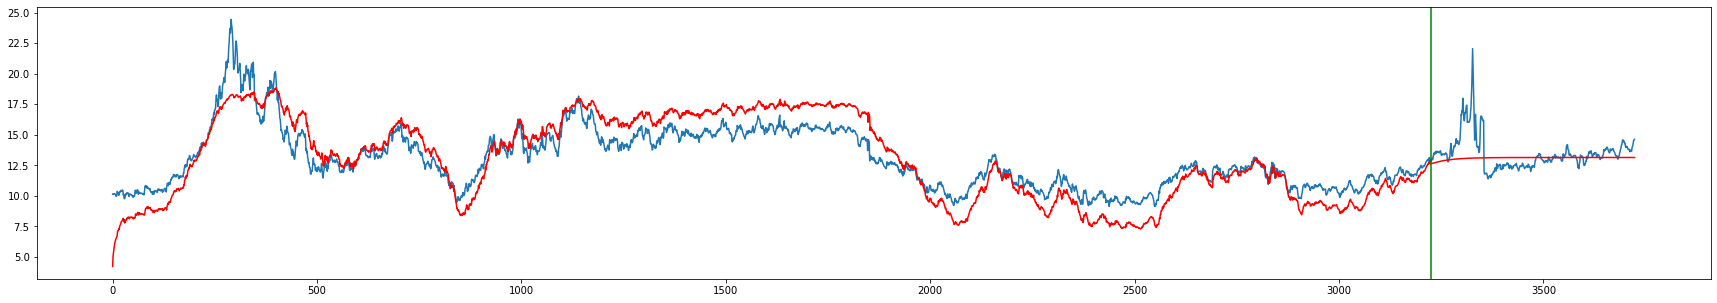

In [37]:
with torch.no_grad():
    future = 500
    pred = lstmModel_oil(x[:-future], future_preds=future)
    # print(pred[0])
    bigPred = pred.detach().numpy()

a = np.mean(bigPred)
b = bigPred+(bigPred-a)*30

print(sum((y - bigPred)**2))

plt.plot(y[10:])
plt.plot(b[10:], color="r")
plt.axvline(x=len(b[10:])-testLength, color="g")
plt.show()

In [30]:
bigPred

array([ 4.112198, 12.333061,  4.337681, ..., 12.850056, 12.85474 ,
       12.855579], dtype=float32)

In [44]:
x = np.array(joinData2[["Price"]], dtype=float)

num_features = 1
num_samples = len(x) - 1

y = torch.tensor(x[1:,0], dtype=torch.float32)
x = torch.tensor(x[:-1, 0], dtype=torch.float32)


In [45]:
print(sum((y - x)**2))
# x

tensor(204.0442)
